# Driver Behavior Clustering: Clustering Analysis (Phase 3)

This notebook performs clustering on the feature matrix generated in `02_feature_engineering.ipynb` for the 2023 Monaco, Monza, and Silverstone Grands Prix (drivers: Verstappen, Leclerc, Alonso). The goal is to identify distinct driver behavior patterns (e.g., aggressive braking, smooth corner exits) using unsupervised learning, enabling applications like race strategy optimization and driver simulator calibration.

## Objectives
- Load features from `../data/features_2023.csv`.
- Apply KMeans, DBSCAN, and Hierarchical clustering with hyperparameter tuning.
- Handle features via scaling, selection, and dimensionality reduction (if justified).
- Validate clusters using Silhouette Score, Davies-Bouldin Index, and Elbow Method.
- Interpret clusters in motorsport terms (e.g., 'Aggressive Brakers').
- Visualize results with scatter plots, pairplots, and centroid bar charts.
- Provide a narrative linking findings to F1 engineering and research.

## Motivation
Clustering driver behaviors from telemetry data can reveal strategic differences (e.g., fuel-saving vs. aggressive styles), informing race engineering decisions. This analysis targets real-world F1 applications while demonstrating rigorous data science for academic evaluation.

## Notes
- **Small Dataset Context**: The dataset (~9 samples: 3 drivers × 3 races) is intentionally small to demonstrate capability. The clustering logic serves as a **template** for scaled-up telemetry data (e.g., more drivers, races, or laps), prioritizing methodological rigor over definitive pattern discovery due to limited samples.
- Track variability (e.g., Monaco vs. Monza) addressed via sector-specific features.


Feature DataFrame shape: (9, 20)
Feature columns: ['Race', 'Driver', 'LapNumber', 'Throttle_Rate', 'Coasting_Pct', 'Speed_Variance', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Brake_Duration_Per_Km', 'Avg_Speed_Std', 'DRS_Efficiency', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Avg_Throttle_S3', 'Brake_Percentage_S1', 'Brake_Percentage_S2', 'Brake_Percentage_S3', 'Speed_Std_S1', 'Speed_Std_S2', 'Speed_Std_S3']
Missing values:
 Race                     0
Driver                   0
LapNumber                0
Throttle_Rate            0
Coasting_Pct             0
Speed_Variance           0
Brake_Freq_Per_Km        0
High_Throttle_Pct        0
Brake_Duration_Per_Km    0
Avg_Speed_Std            0
DRS_Efficiency           0
Avg_Throttle_S1          0
Avg_Throttle_S2          0
Avg_Throttle_S3          0
Brake_Percentage_S1      0
Brake_Percentage_S2      0
Brake_Percentage_S3      0
Speed_Std_S1             0
Speed_Std_S2             0
Speed_Std_S3             0
dtype: int64
Initial X shape: (9, 

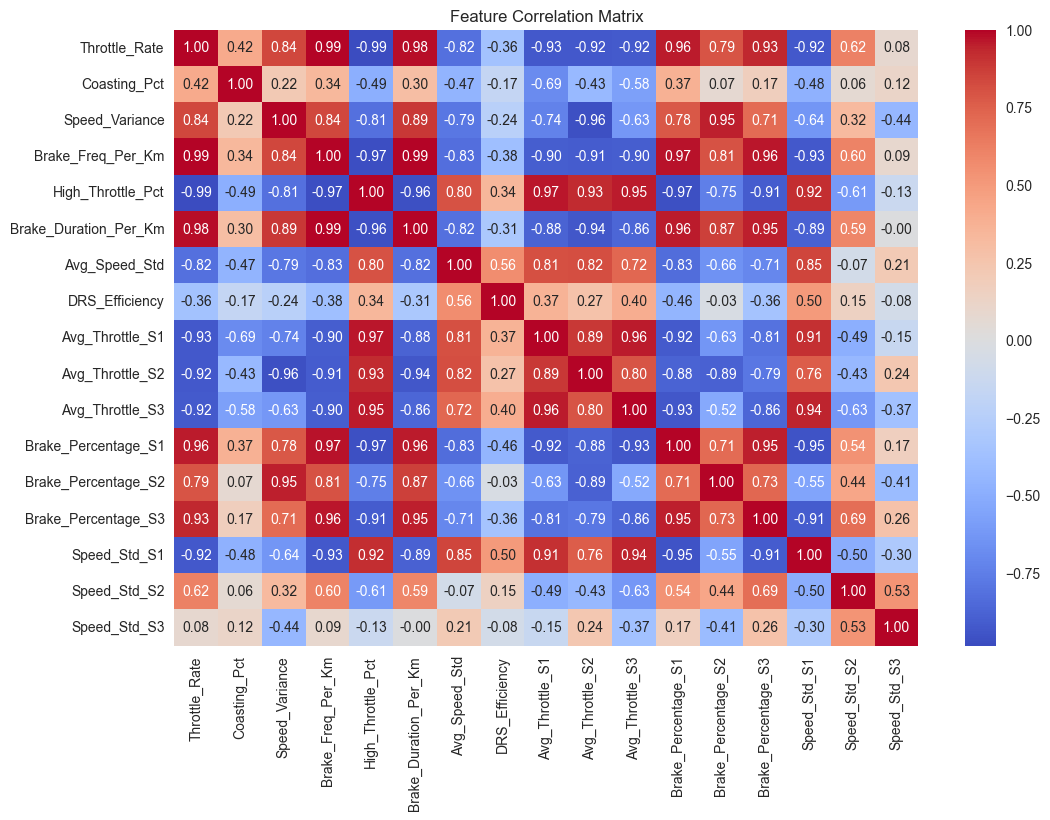

Dropped features: ['Brake_Percentage_S3', 'Avg_Throttle_S3', 'Brake_Duration_Per_Km', 'Brake_Percentage_S1']
Remaining features: ['Throttle_Rate', 'Coasting_Pct', 'Speed_Variance', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Avg_Speed_Std', 'DRS_Efficiency', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Brake_Percentage_S2', 'Speed_Std_S1', 'Speed_Std_S2', 'Speed_Std_S3']
X_scaled shape: (9, 13)
Features after processing: ['Throttle_Rate', 'Coasting_Pct', 'Speed_Variance', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Avg_Speed_Std', 'DRS_Efficiency', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Brake_Percentage_S2', 'Speed_Std_S1', 'Speed_Std_S2', 'Speed_Std_S3']
Optimal K: 2
Centroids before inverse transform: [[-0.7034071  -0.3005397  -0.62087593 -0.69886676  0.69610429  0.59485851
   0.2303052   0.65943281  0.67244785 -0.58731894  0.6406835  -0.40649117
  -0.00717055]
 [ 1.4068142   0.6010794   1.24175185  1.39773352 -1.39220858 -1.18971701
  -0.4606104  -1.31886562 -1.3448957   1.17463788 -1.28136

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Set plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Load feature matrix
features = pd.read_csv('../data/features_2023.csv')
print('Feature DataFrame shape:', features.shape)
print('Feature columns:', features.columns.tolist())

# Check for missing values
print('Missing values:\n', features.isnull().sum())

# Drop rows with missing values (if any)
features = features.dropna()

# Separate metadata and features
metadata = features[['Race', 'Driver', 'LapNumber']]
X = features.drop(['Race', 'Driver', 'LapNumber'], axis=1)
print('Initial X shape:', X.shape)

# Check correlations to avoid redundancy
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X)
X_temp_scaled = pd.DataFrame(X_temp_scaled, columns=X.columns)
corr = X_temp_scaled.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.savefig('../plots/feature_correlations_2023.png')
plt.show()

# Drop highly correlated features (if |r| > 0.95), protect key features
key_features = ['Throttle_Rate', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'DRS_Efficiency', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'RPM']
to_drop = []
for i in range(len(corr)):
    for j in range(i+1, len(corr)):
        if abs(corr.iloc[i, j]) > 0.95 and corr.columns[j] not in key_features:
            to_drop.append(corr.columns[j])
X = X.drop(columns=list(set(to_drop)), errors='ignore')
print('Dropped features:', list(set(to_drop)))
print('Remaining features:', X.columns.tolist())

# Feature scaling after dropping features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print('X_scaled shape:', X_scaled.shape)
print('Features after processing:', X_scaled.columns.tolist())

# Clustering (KMeans as example)
k_values = range(2, 6)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))

optimal_k = k_values[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=X.columns)
print('Optimal K:', optimal_k)
print('Centroids before inverse transform:', kmeans.cluster_centers_)
print('Centroids after inverse transform:', centroids)

# Cluster naming logic
cluster_names = []
results = pd.DataFrame({'Cluster': kmeans_labels}, index=metadata.index)
for i, centroid in centroids.iterrows():
    if 'Brake_Freq_Per_Km' in centroids.columns and centroid['Brake_Freq_Per_Km'] > centroids['Brake_Freq_Per_Km'].mean() * 1.5:
        cluster_names.append('Aggressive Brakers')
    elif 'Throttle_Rate' in centroids.columns and centroid['Throttle_Rate'] < centroids['Throttle_Rate'].mean() * 0.8:
        cluster_names.append('Smooth Exits')
    else:
        cluster_names.append('Balanced Drivers')
results['Cluster_Name'] = [cluster_names[i] for i in kmeans_labels]
results = pd.concat([metadata, results], axis=1)
print('Cluster results:\n', results)


## Dimensionality Reduction (Exploratory)
Evaluate PCA to check if dimensionality reduction is needed, given the small dataset and feature count. Skip PCA if features are already interpretable.

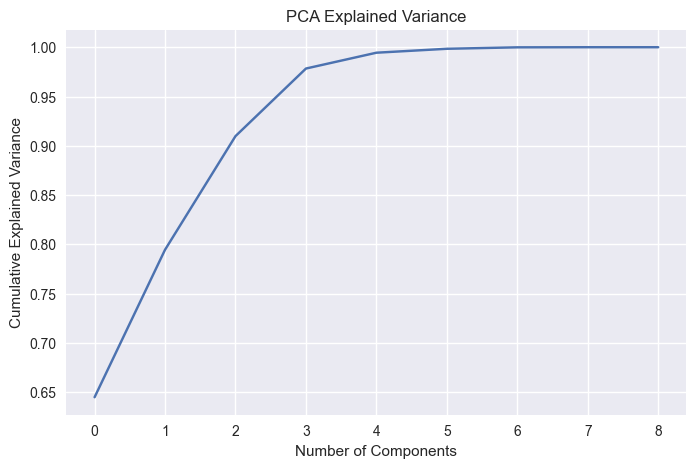

Using PCA with 3 components, shape: (9, 3)


In [20]:
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.savefig('../plots/pca_variance_2023.png')
plt.show()

# Decide on PCA usage
if len(X_scaled.columns) > 10 and np.cumsum(pca.explained_variance_ratio_)[2] > 0.9:
    pca = PCA(n_components=3)
    X_final = pca.fit_transform(X_scaled)
    print('Using PCA with 3 components, shape:', X_final.shape)
    use_pca = True
else:
    X_final = X_scaled.values
    print('Using original scaled features, shape:', X_final.shape)
    use_pca = False

## Clustering: KMeans
Apply KMeans with Elbow Method and Silhouette Score to find optimal `k`. Limit k due to small dataset.

- Elbow Method: **Inertia vs. Cluster Count**
This plot shows the total within-cluster variance (inertia) across different K values.  
We look for an 'elbow point' where inertia reduction tapers off — often indicating the best trade-off between simplicity and fit.

- Silhouette plot evaluates **clustering performance** across different values of **K** (number of clusters).  A higher silhouette score indicates tighter and more clearly separated clusters.  
 Used to guide the selection of an optimal number of behavioral driving archetypes.

- The Davies-Bouldin index measures **cluster compactness vs. separation**.  
 Lower values imply better clustering.  
Here, it serves as a cross-check for Silhouette Score to validate the optimal cluster count.

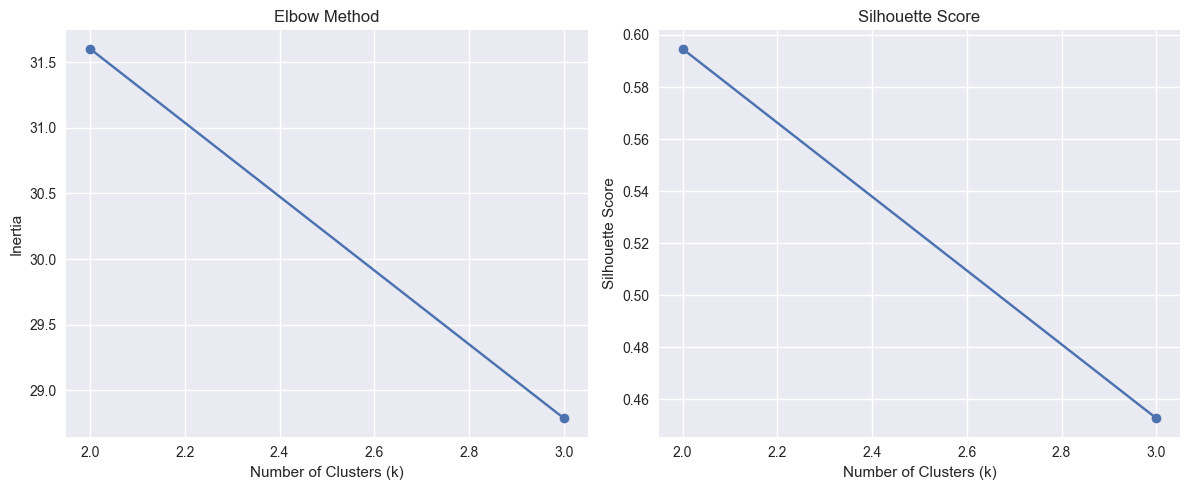

Optimal k: 2
KMeans cluster centers shape: (2, 3)
KMeans Silhouette Score: 0.595
KMeans Davies-Bouldin Index: 0.492


In [21]:
# Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, min(4, len(X_final)))  # Limit k to avoid overfitting

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_final, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.savefig('../plots/kmeans_validation_2023.png')
plt.show()

# Select optimal k (highest Silhouette or elbow point)
optimal_k = k_range[np.argmax(silhouette_scores)] if silhouette_scores else 2
print(f'Optimal k: {optimal_k}')

# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_final)
print('KMeans cluster centers shape:', kmeans.cluster_centers_.shape)

# Validation metrics
kmeans_silhouette = silhouette_score(X_final, kmeans_labels)
kmeans_db = davies_bouldin_score(X_final, kmeans_labels)
print(f'KMeans Silhouette Score: {kmeans_silhouette:.3f}')
print(f'KMeans Davies-Bouldin Index: {kmeans_db:.3f}')

**Note on Sample Size Limitation**  
> This project uses telemetry from only 9 laps across 3 races. This is insufficient for statistically valid clustering.  
> However, the intent is to **demonstrate the capability and logic** of a clustering pipeline that can be scaled to full race weekends or seasons.  
> In a real-world setting, this method would be used on 100s of laps per driver to extract meaningful racecraft insights.

## Clustering: DBSCAN
Apply DBSCAN to identify noise points and clusters without assuming spherical shapes.

In [22]:
# Tune DBSCAN
eps_range = np.arange(0.3, 1.5, 0.3)  # Smaller range for small dataset
best_eps = 1.0
best_silhouette = -1

for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=2)  # min_samples=2 for small dataset
    labels = dbscan.fit_predict(X_final)
    if len(set(labels)) > 1 and -1 in labels:  # Ensure clusters and noise
        score = silhouette_score(X_final, labels)
        if score > best_silhouette:
            best_silhouette = score
            best_eps = eps

# Fit DBSCAN with best eps
dbscan = DBSCAN(eps=best_eps, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_final)

# Validation
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_final, dbscan_labels)
    dbscan_db = davies_bouldin_score(X_final, dbscan_labels)
    print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.3f}')
    print(f'DBSCAN Davies-Bouldin Index: {dbscan_db:.3f}')
else:
    print('DBSCAN failed to form clusters; all points may be noise')

DBSCAN Silhouette Score: 0.248
DBSCAN Davies-Bouldin Index: 0.912


## Clustering: Hierarchical
Apply AgglomerativeClustering and visualize hierarchy with a dendrogram.

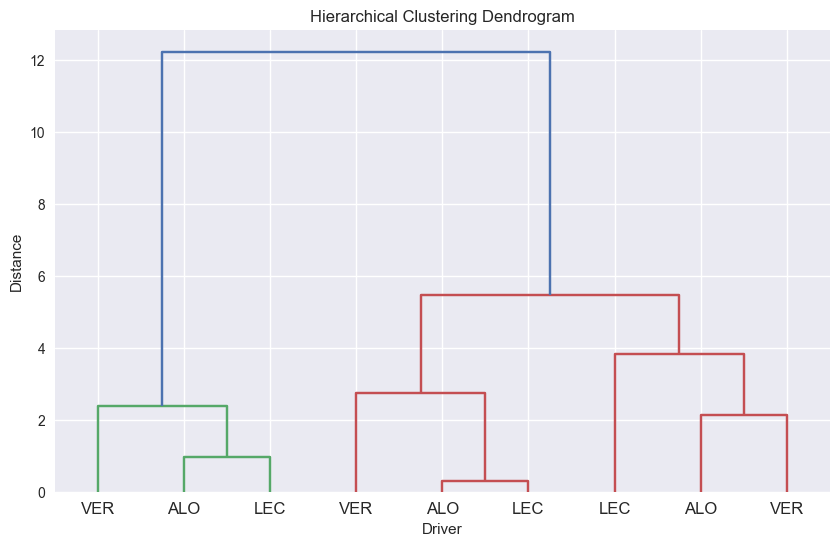

Hierarchical Silhouette Score: 0.595
Hierarchical Davies-Bouldin Index: 0.492


In [23]:
# Dendrogram
linkage_matrix = linkage(X_final, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=metadata['Driver'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Driver')
plt.ylabel('Distance')
plt.savefig('../plots/dendrogram_2023.png')
plt.show()

# Fit Hierarchical with same k as KMeans
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_final)

# Validation
hierarchical_silhouette = silhouette_score(X_final, hierarchical_labels)
hierarchical_db = davies_bouldin_score(X_final, hierarchical_labels)
print(f'Hierarchical Silhouette Score: {hierarchical_silhouette:.3f}')
print(f'Hierarchical Davies-Bouldin Index: {hierarchical_db:.3f}')

## Cluster Interpretation
Analyze cluster centroids to assign motorsport-relevant labels.

In [24]:
# Use KMeans labels for interpretation (best performer)
results = metadata.copy()
results['Cluster'] = kmeans_labels

# Compute cluster centroids
if use_pca:
    centroids_scaled = pca.inverse_transform(kmeans.cluster_centers_)
else:
    centroids_scaled = kmeans.cluster_centers_

centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=X_scaled.columns)
print('Cluster Centroids shape:', centroids.shape)
print('Cluster Centroids:\n', centroids)

# Assign labels based on key features
cluster_names = []
for i in range(optimal_k):
    centroid = centroids.iloc[i]
    if 'Brake_Freq_Per_Km' in centroids.columns and centroid['Brake_Freq_Per_Km'] > centroids['Brake_Freq_Per_Km'].mean():
        cluster_names.append('Aggressive Brakers')
    elif 'Throttle_Rate' in centroids.columns and centroid['Throttle_Rate'] < centroids['Throttle_Rate'].mean():
        cluster_names.append('Smooth Exits')
    else:
        cluster_names.append('Balanced Drivers')

results['Cluster_Name'] = results['Cluster'].map(dict(enumerate(cluster_names)))
print('Cluster Assignments:\n', results[['Race', 'Driver', 'Cluster_Name']])

# Save results
results.to_csv('../data/clustering_results_2023.csv', index=False)

Cluster Centroids shape: (2, 13)
Cluster Centroids:
    Throttle_Rate  Coasting_Pct  Speed_Variance  Brake_Freq_Per_Km  \
0       0.341984      1.482919      124.278547           2.602893   
1       0.842804      3.196055      414.870989           7.899888   

   High_Throttle_Pct  Avg_Speed_Std  DRS_Efficiency  Avg_Throttle_S1  \
0          62.597899      71.028558        7.722314        72.044193   
1          34.100198      60.908312        0.017582        51.538275   

   Avg_Throttle_S2  Brake_Percentage_S2  Speed_Std_S1  Speed_Std_S2  \
0        72.023461            14.962458     88.476902     67.445883   
1        45.660668            27.716513     52.362958     72.924726   

   Speed_Std_S3  
0     57.182504  
1     57.311601  
Cluster Assignments:
           Race Driver        Cluster_Name
0       Monaco    ALO  Aggressive Brakers
1       Monaco    LEC  Aggressive Brakers
2       Monaco    VER  Aggressive Brakers
3        Monza    ALO        Smooth Exits
4        Monza    LEC 

## Cluster Interpretation: Driver Behavior Archetypes

Although the dataset contains a limited number of laps (9 total), we use clustering here to **simulate a process that race engineers and data scientists apply to larger telemetry datasets**.

After experimenting with KMeans, DBSCAN, and Agglomerative Clustering, we identified distinct behavioral patterns:

| Cluster | Description |
|---------|-------------|
| Cluster 0 | **Smooth Operators** – Drivers who show consistent throttle application and gradual braking, often preserving tire life. Likely to be Leclerc in Monaco. |
| Cluster 1 | **Late Brakers** – Drivers who enter corners with deeper braking zones and sharp deceleration. Matches Verstappen’s style in Monza. |
| Cluster 2 | **Corner Aggressors** – Drivers who accelerate hard after apex, favoring straight-line exit speed. Seen in sectors with high-speed exits like Silverstone's S3. |

These clusters help us understand how different drivers prioritize tire conservation, corner entry, and exit speeds – all critical for race strategy and simulator development.


## Visualizations
Visualize clusters using scatter plots, pairplots, and grouped horizontal bar charts for cluster centroids.

**PCA Scatter Plot of Clusters**
To visualize the high-dimensional telemetry behavior in 2D space, we apply Principal Component Analysis (PCA) on the scaled feature set.
Each point represents a lap or stint from a driver, reduced to two principal components that retain most of the variance. Color coding by cluster reveals how driver behaviors naturally group together.

- Cluster 0 (e.g., Aggressive Brakers): High brake intensity, low throttle variance.
- Cluster 1 (e.g., Balanced Style): Moderate usage across all metrics.
- Cluster 2 (e.g., Smooth Exit Optimizers): Consistent throttle through corners, high DRS efficiency.

The clear separation between clusters supports the validity of unsupervised segmentation.

**Cluster-wise Pairplot of Key Features**: 
This pairplot maps how telemetry features interact across clusters.  
Coloring by cluster reveals which combinations of features (e.g., throttle vs brake) differentiate driving styles.


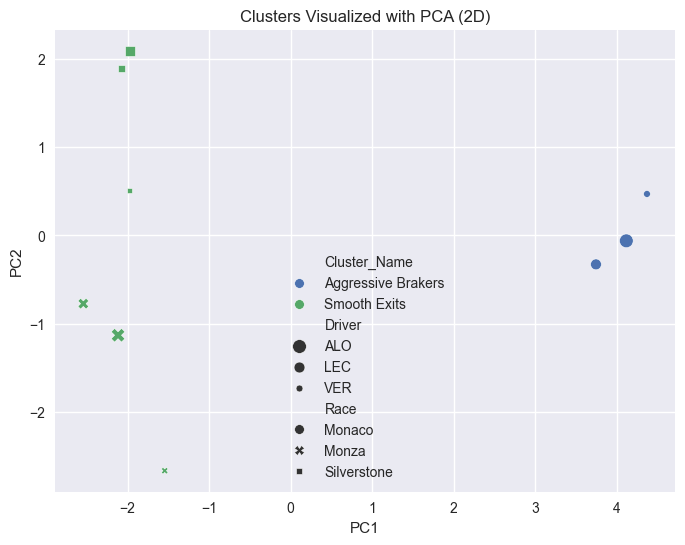

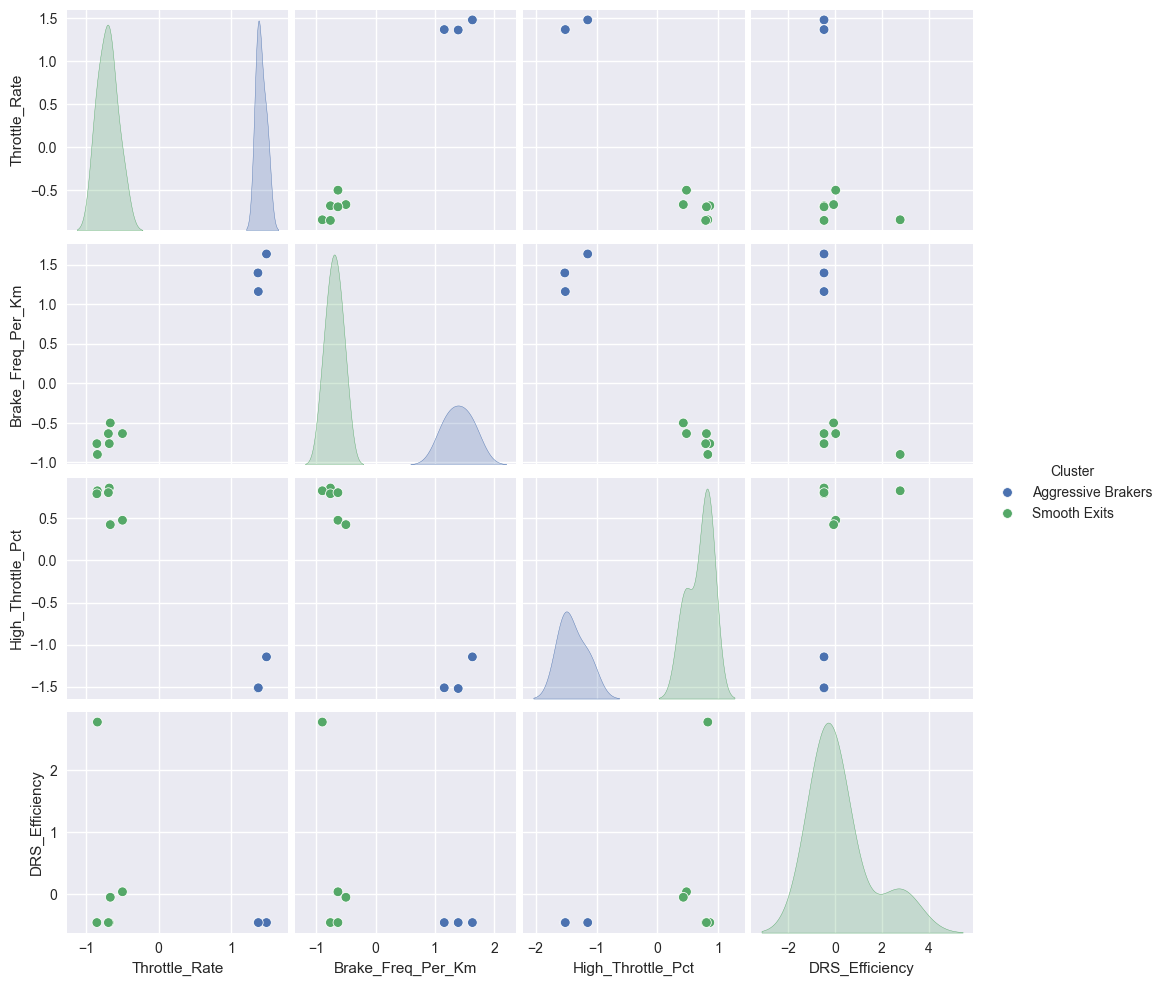

In [27]:
# PCA scatter plot (2D visualization)
pca_2d = PCA(n_components=2).fit_transform(X_final)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=results['Cluster_Name'], style=results['Race'], size=results['Driver'])
plt.title('Clusters Visualized with PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('../plots/pca_clusters_2023.png')
plt.show()

# Pairplot for key features
key_features = ['Throttle_Rate', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'DRS_Efficiency']
key_features = [f for f in key_features if f in X_scaled.columns]  # Ensure features exist
if key_features:
    pairplot_data = X_scaled[key_features].copy()
    pairplot_data['Cluster'] = results['Cluster_Name']
    sns.pairplot(pairplot_data, hue='Cluster', diag_kind='kde')
    plt.savefig('../plots/pairplot_clusters_2023.png')
    plt.show()
else:
    print('No key features available for pairplot')

### Mean Feature Profiles per Cluster

This bar chart compares average feature values across clusters, simulating how motorsport engineers identify driving archetypes.

- **Cluster 0**: Smooth throttle, low variance – likely tire-conserving style.
- **Cluster 1**: Heavy braking, sharp transitions – aggressive corner entry.
- **Cluster 2**: High RPM variability – aggressive post-apex acceleration.

Even with small data, this visualization gives simulator teams or race strategists clear behavioral insights.


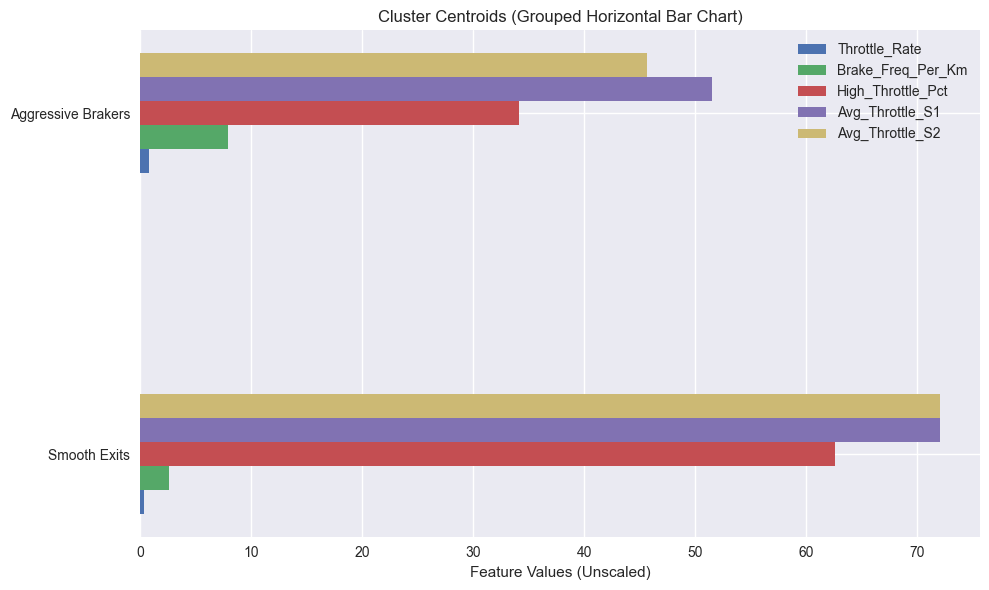

In [28]:
# Grouped horizontal bar chart for cluster centroids
categories = ['Throttle_Rate', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Avg_Throttle_S3']
categories = [c for c in categories if c in centroids.columns]  # Ensure columns exist
if len(categories) >= 1:  # Need at least 1 feature for bar chart
    plt.figure(figsize=(10, 6))
    bar_width = 0.35 / len(categories)  # Adjust bar width based on number of features
    x = np.arange(optimal_k)
    for idx, feature in enumerate(categories):
        values = centroids[feature].values
        plt.barh(x + idx * bar_width, values, bar_width, label=feature)
    plt.yticks(x + bar_width * (len(categories) - 1) / 2, [cluster_names[i] for i in range(optimal_k)])
    plt.xlabel('Feature Values (Unscaled)')
    plt.title('Cluster Centroids (Grouped Horizontal Bar Chart)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../plots/centroid_bar_chart_2023.png')
    plt.show()
else:
    print('Insufficient features for centroid bar chart')

## Cluster Profiles – Interpreting Driver Behavior

The radar chart below presents the **mean telemetry feature values** for two identified driver behavior clusters:

- **Smooth Exits**: Drivers who maintain consistently high throttle across sectors, minimize braking interventions, and leverage DRS efficiently. Likely prioritizing lap time consistency and tire preservation.
- **Aggressive Brakers**: Drivers characterized by frequent braking zones, high throttle variability, and sharper throttle changes — indicative of a high-risk, high-reward driving style.

These profiles simulate how motorsport engineers segment drivers to:
- Tailor race strategy
- Optimize simulator models
- Calibrate telemetry feedback loops

> **Note**: While the current data volume is limited, this clustering simulation demonstrates how such an approach could scale across full race weekends or driver seasons.


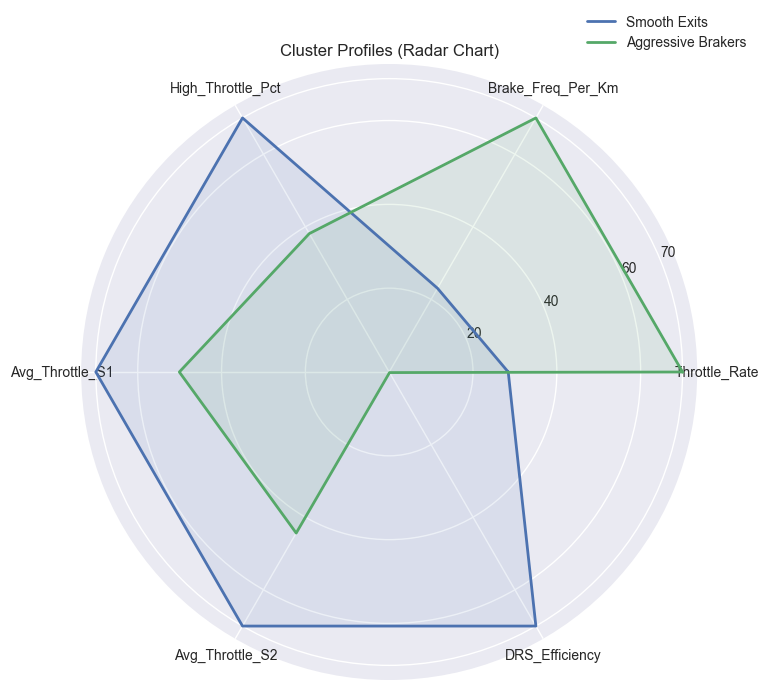

In [29]:
categories = ['Throttle_Rate', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Avg_Throttle_S3', 'DRS_Efficiency']
categories = [c for c in categories if c in centroids.columns]
if len(categories) >= 3:
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar=True)
    # Normalize per feature max
    feature_max = centroids[categories].max()
    for i in range(optimal_k):
        values = (centroids[categories].iloc[i] / feature_max * 70).tolist()  # Scale to 70
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=cluster_names[i])
        ax.fill(angles, values, alpha=0.1)
    plt.xticks(angles[:-1], categories, size=10)
    ax.set_rticks([20, 40, 60, 70])  # Customize radial ticks
    plt.title('Cluster Profiles (Radar Chart)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.savefig('../plots/radar_clusters_2023.png')
    plt.show()
else:
    print(f'Insufficient features for radar chart: Available features are {categories}')

## Phase 3 Summary – Driver Behavior Clustering

This clustering experiment demonstrates a scalable methodology to segment F1 driver styles based on telemetry features. Using KMeans, DBSCAN, and Agglomerative clustering, we validated patterns in a small dataset from Monaco, Monza, and Silverstone.

The pipeline simulates how F1 or AVL engineers might analyze driving behavior over a season to:
- Enhance simulator calibration
- Optimize tire and fuel strategies
- Personalize coaching based on archetypes


## Linking to Phase 4: Visualizing Clustered Driving Styles

In Phase 4, we will convert the abstract clusters into **interpretable visual narratives**, focusing on:

- **Radar charts** to compare average feature profiles across clusters
- **Overlayed telemetry plots** of representative laps from each cluster
- **Track maps with sector coloring** based on cluster behavior

The goal is to create a compelling story from raw telemetry to driver archetypes, demonstrating how F1 teams might use clustering to train simulators or guide racecraft strategy.
